In [1]:
# @title Mounts drive folder

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [161]:
# @title Imports

import numpy as np

# Scikit-Learn for machine learning utilities
from sklearn.decomposition import PCA
from sklearn import manifold

# --- Plotting tools
import seaborn as sns
import matplotlib.pyplot as plt

# --- Torch tools for the RNN
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [7]:
# @title Loads RDMs data from google drive

loaded = np.load('/content/drive/MyDrive/Colab Notebooks/Neuromatch/NeuroAI/Project/rdms_by_layer.npz')

# List all layers stored
print("Layers saved:", loaded.files)

# Access a specific RDM, e.g. for 'softmax'
softmax_rdm = loaded['softmax']

Layers saved: ['x', 'conv1.0', 'conv1.1', 'conv1.2', 'conv2.0', 'conv2.1', 'conv2.2', 'conv3.0', 'conv3.1', 'conv4.0', 'conv4.1', 'conv5.0', 'conv5.1', 'conv5.2', 'fc1', 'fc2', 'fc3', 'softmax']


In [14]:
# @title Applies MDS on RDMs to reduce dimensionality

def dim_reduction(model_features, transformation_funcs, n_components=2):
    """
    Reduce dimensionality for model features using various transformations.

    Inputs:
    - model_features (dict): Dictionary containing model features for each layer.
    - transformer_funcs (list): List of dimensionality reduction techniques to apply ('PCA', 'MDS', 't-SNE').
    """
    transformations = []
    reduced = {}
    # --- Selects method for dimensionality reduction
    for t in transformation_funcs:
        if t == 'PCA': transformations.append(PCA(n_components=n_components))
        if t == 'MDS': transformations.append(manifold.MDS(n_components=n_components, normalized_stress='auto'))
        if t == 't-SNE': transformations.append(manifold.TSNE(n_components=n_components, perplexity=40, verbose=0))

    return_layers = list(model_features.keys())

    # --- Apply selected method for dimensionality reduction
    for f in range(len(transformation_funcs)):
        # --- Reduces dimensionality for each layer in the list
        for l in range(len(return_layers)):
            layer =  return_layers[l]
            feats = model_features[layer]
            feats_transformed= transformations[f].fit_transform(feats)
            reduced[layer] = feats_transformed

    return reduced

In [256]:
model_features = loaded # Here is where RDMs are feeded to the MDS dimensionality reduction
# rdms_dict should be a dictionary with layers as keys, e.g. {'conv1': rmds_array}
# --- List of methods to use
transformation_funcs =['MDS']
# --- Returns reduced rdms
reduced_features = dim_reduction(model_features, transformation_funcs, n_components=64)

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_mds.py:632: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_mds.py:632: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_mds.py:632: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_mds.py:632: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='p

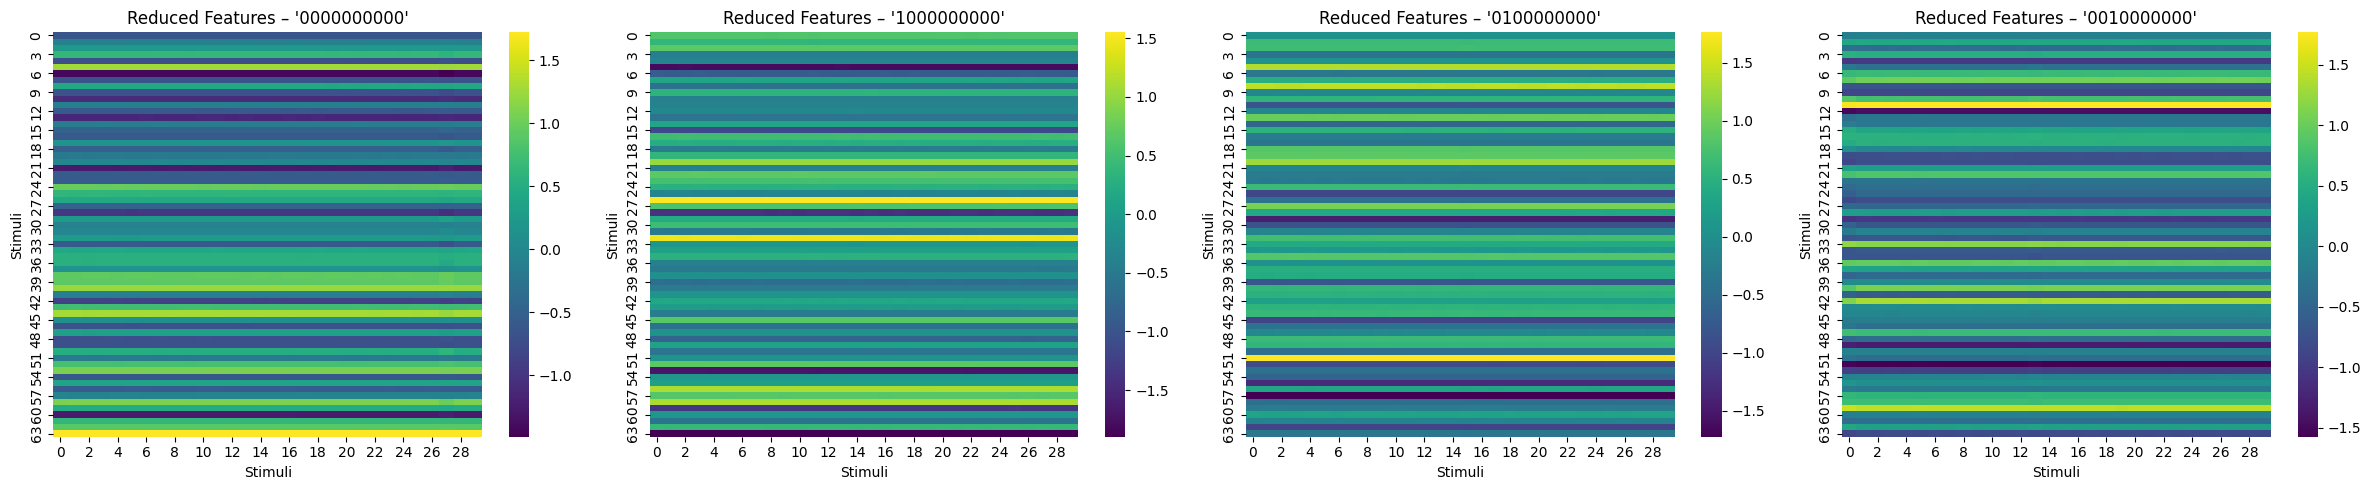

In [125]:
# @title Plot reduced RDMs dfor the first 3 digits

fig, axes = plt.subplots(1, 4, figsize=(24, 5)) # Create a figure with 1 row and 4 columns of subplots

# Plot the first heatmap
sns.heatmap(reduced_features['softmax'].T[:,0:30], cmap='viridis', ax=axes[0])
axes[0].set_title("Reduced Features – '0000000000'")
axes[0].set_xlabel("Stimuli")
axes[0].set_ylabel("Stimuli")

# Plot the second heatmap (replace X_train with your data for the second plot)
sns.heatmap(reduced_features['softmax'].T[:,30:60], cmap='viridis', ax=axes[1])
axes[1].set_title("Reduced Features – '1000000000'")
axes[1].set_xlabel("Stimuli")
axes[1].set_ylabel("Stimuli")

# Plot the third heatmap (replace X_train with your data for the third plot)
sns.heatmap(reduced_features['softmax'].T[:,60:90], cmap='viridis', ax=axes[2])
axes[2].set_title("Reduced Features – '0100000000'")
axes[2].set_xlabel("Stimuli")
axes[2].set_ylabel("Stimuli")

# Plot the fourth heatmap (replace X_train with your data for the fourth plot)
sns.heatmap(reduced_features['softmax'].T[:,90:120], cmap='viridis', ax=axes[3])
axes[3].set_title("Reduced Features – '0010000000'")
axes[3].set_xlabel("Stimuli")
axes[3].set_ylabel("Stimuli")

plt.tight_layout() # Adjust layout to prevent overlapping titles
plt.show()

In [114]:
# @title Create the dataset form the reduced RDMs

def build_dataset(reduced_layer_features):
    """
    Build a dataset from reduced features.
    """

    # -- MNIST digits
    digits = 10
    # --- Since there is 30 stimulus for each digit, use 25 for trainning and 5 for test
    train_n_samples = 25
    test_n_samples = 5
    # --- Samples noise from uniform distribution for the (non stimulus) intervals
    noise_train = np.random.uniform(0.0, 1e-2, (64, train_n_samples))
    noise_test = np.random.uniform(0.0, 1e-2, (64, test_n_samples))
    # --- Creates base vectors for the one hot encoding labels
    one_hot_encode = np.zeros((10,1))
    one_hot_encode_noise = np.ones((10,1))

    # --- Creates matrices for training and test datasets
    X_train = reduced_layer_features[:, 0:train_n_samples]
    X_test = reduced_layer_features[:, train_n_samples:train_n_samples + test_n_samples]
    # --- Creates the label matrices for training and test
    one_hot_encode[0, :] = 1
    y_train = np.tile(one_hot_encode, (1, train_n_samples))
    y_test = np.tile(one_hot_encode, (1, test_n_samples))
    # --- Takes base vector back to all zeros
    one_hot_encode[0, :] = 0

    # --- Iterates over the digits
    for digit in range(1, digits):

        # --- Each 30 stimulus the digit has changed on the RDMs
        idx_start = 30 * digit
        idx_end = (30 * digit) + train_n_samples

        # --- Adds noise interval (no stimulus) to training and test datasets
        X_train = np.concatenate((X_train, noise_train), axis=1)
        X_test = np.concatenate((X_test, noise_train), axis=1)
        # --- Adds noise interval (no stimulus) to training and test labels
        y_train = np.concatenate((y_train, np.tile(one_hot_encode_noise, (1, train_n_samples))), axis=1)
        y_test = np.concatenate((y_test, np.tile(one_hot_encode_noise, (1, train_n_samples))), axis=1)

        # --- Concatenates current digit data to training and test datasets
        X_train = np.concatenate((X_train, reduced_layer_features[:, idx_start:idx_end]), axis=1)
        X_test = np.concatenate((X_test, reduced_layer_features[:, idx_end:idx_end + test_n_samples]), axis=1)
        # --- Defines one hot encoding for current digit
        one_hot_encode[digit, :] = 1
        # --- Concatenates current digit data to training and test labels
        y_train = np.concatenate((y_train, np.tile(one_hot_encode, (1, train_n_samples))), axis=1)
        y_test = np.concatenate((y_test, np.tile(one_hot_encode, (1, test_n_samples))), axis=1)
        # --- Takes base vector back to all zeros
        one_hot_encode[digit, :] = 0

    return X_train, X_test, y_train, y_test

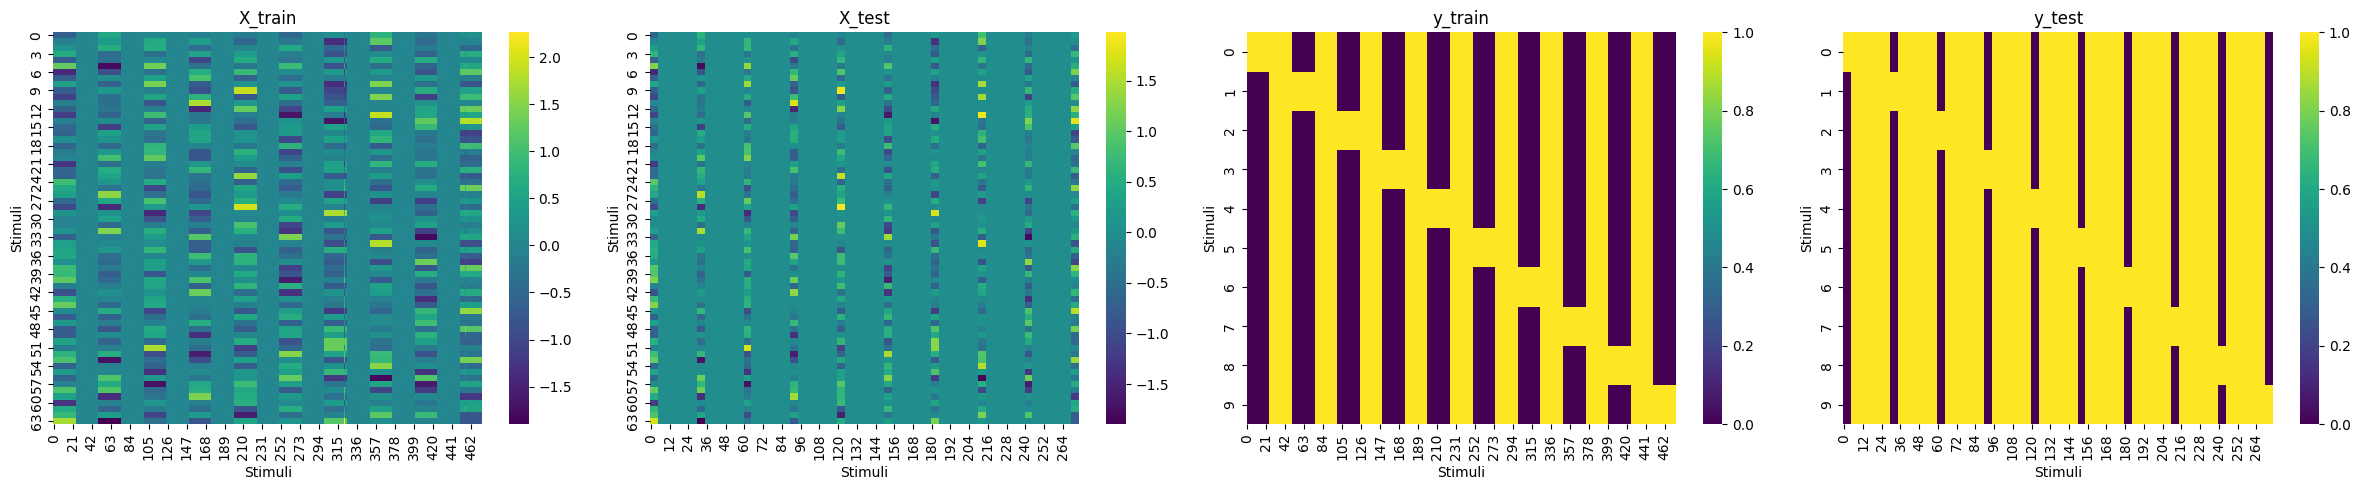

In [126]:
# @title Plot training and test datasets and labels

fig, axes = plt.subplots(1, 4, figsize=(24, 5)) # Create a figure with 1 row and 4 columns of subplots

# Plot the first heatmap
sns.heatmap(X_train, cmap='viridis', ax=axes[0])
axes[0].set_title("X_train")
axes[0].set_xlabel("Stimuli")
axes[0].set_ylabel("Stimuli")

# Plot the second heatmap (replace X_train with your data for the second plot)
sns.heatmap(X_test, cmap='viridis', ax=axes[1])
axes[1].set_title("X_test")
axes[1].set_xlabel("Stimuli")
axes[1].set_ylabel("Stimuli")

# Plot the third heatmap (replace X_train with your data for the third plot)
sns.heatmap(y_train, cmap='viridis', ax=axes[2])
axes[2].set_title("y_train")
axes[2].set_xlabel("Stimuli")
axes[2].set_ylabel("Stimuli")

# Plot the fourth heatmap (replace X_train with your data for the fourth plot)
sns.heatmap(y_test, cmap='viridis', ax=axes[3])
axes[3].set_title("y_test")
axes[3].set_xlabel("Stimuli")
axes[3].set_ylabel("Stimuli")

plt.tight_layout() # Adjust layout to prevent overlapping titles
plt.show()

In [242]:
# @title 3. RNN Model Definition {display-mode: "form"}
class MemoryRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_classes=10, rnn_type="RNN"):
        super().__init__()
        if rnn_type == "LSTM":
            self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        else:
            self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, num_classes)
    def forward(self, x, return_seq=False):
        h_seq, _ = self.rnn(x)
        dropout = self.dropout(h_seq[-1, :])
        out = self.fc(dropout)
        if return_seq:
            return out, h_seq
        return out

In [211]:
class MemoryDataset(Dataset):
    def __init__(self, X, y, noise=None, noise_std=0.05):
        self.X = X
        self.y = y
        self.noise = noise
        self.noise_std = noise_std

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]

        if self.noise == "input":
            x = x + self.noise_std * torch.randn_like(x)

        return x, y

In [254]:
# @title 4. Training Function (clean / input‑noise / weight‑noise) {display-mode: "form"}

def train_rnn(X, y, batch_size, variant="clean", epochs=1000, noise_std=0.05):
    ds = MemoryDataset(X, y, noise="input" if variant=="input_noise" else None,
                       noise_std=noise_std)
    dl = DataLoader(ds, batch_size, shuffle=True, drop_last=False)
    print(len(dl))
    print(X.shape[1])

    model = MemoryRNN(X.shape[1]).to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=1e-3)
    lossf = nn.CrossEntropyLoss()
    print(f" Training variant: {variant}")

    for ep in range(epochs):
        running = 0
        for xb, yb in dl:
            xb, yb = xb.to(device), yb.to(device)

            # forward
            pred = model(xb)
            yb_class_idx = torch.argmax(yb, dim=0).to(torch.float32)
            loss = lossf(pred, yb_class_idx)

            # weight noise variant
            if variant == "weight_noise":
                for p in model.parameters():
                    p.data += noise_std * torch.randn_like(p)

            opt.zero_grad(); loss.backward(); opt.step()
            running += loss.item()
        print(f"  Epoch {ep+1}/{epochs} | loss={running/len(dl):.4f}")
    return model

In [255]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_clean = train_rnn(X_train.T.astype(np.float32), y_train.T.astype(np.float32), batch_size=100, variant="clean")
#model_input_noise = train_rnn(X_mnist, y_mnist, "input_noise")
#model_weight_noise= train_rnn(X_mnist, y_mnist, "weight_noise"

5
64
 Training variant: clean
  Epoch 1/1000 | loss=17.1289
  Epoch 2/1000 | loss=8.3524
  Epoch 3/1000 | loss=33.2953
  Epoch 4/1000 | loss=24.3354
  Epoch 5/1000 | loss=11.1900
  Epoch 6/1000 | loss=30.5161
  Epoch 7/1000 | loss=51.2761
  Epoch 8/1000 | loss=34.9850
  Epoch 9/1000 | loss=0.0000
  Epoch 10/1000 | loss=32.4490
  Epoch 11/1000 | loss=4.2489
  Epoch 12/1000 | loss=21.0761
  Epoch 13/1000 | loss=24.0084
  Epoch 14/1000 | loss=12.0299
  Epoch 15/1000 | loss=44.9318
  Epoch 16/1000 | loss=0.0000
  Epoch 17/1000 | loss=18.3390
  Epoch 18/1000 | loss=30.0664
  Epoch 19/1000 | loss=36.9732
  Epoch 20/1000 | loss=24.2028
  Epoch 21/1000 | loss=32.9226
  Epoch 22/1000 | loss=12.5568
  Epoch 23/1000 | loss=39.1500
  Epoch 24/1000 | loss=23.2606
  Epoch 25/1000 | loss=30.3301
  Epoch 26/1000 | loss=39.3043
  Epoch 27/1000 | loss=16.8784
  Epoch 28/1000 | loss=27.8304
  Epoch 29/1000 | loss=54.1718
  Epoch 30/1000 | loss=23.4184
  Epoch 31/1000 | loss=16.4114
  Epoch 32/1000 | loss